In [1]:
import pandas as pd
import os
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from itertools import cycle

In [2]:
df_Camera_list = []
df_Touch_list = []
for root, dirs, files in os.walk("Recordings/"):
    for file in files:
        file_path = os.path.join(root, file)
        #print(f"Reading: {file_path}")
        df = pd.read_csv(file_path , sep = '\t')
        if "Tshirt" in file_path:
            df['Clothing'] = 'Tshirt'
        else: 
            df['Clothing'] = 'Jacket'
        if 'Camera' in file_path:
            df_Camera_list.append(df)
        else:
            df_Touch_list.append(df)
print(len(df_Camera_list), len(df_Touch_list))         

40 10


## Analysis of Touch Dynamics
### Plotting 

In [3]:
# Function to assign unique touch sequence IDs based on 'down' and 'up' events
def assign_touch_sequence_ids(df):
    sequence_id = 0
    ids = []
    touch_active = False
    for index, row in df.iterrows():
        if row['down'] == 1 and not touch_active:
            sequence_id += 1
            touch_active = True
        if row['up'] == 1 and touch_active:
            touch_active = False
        ids.append(sequence_id)
    return ids

In [4]:
def plot_touch_sequences(data):
    
    # Assign touch sequence IDs
    data['touch_sequence_id'] = assign_touch_sequence_ids(data)
    
    # Filtering out sequences with actual movement
    filtered_data = data[data['touch_sequence_id'] > 0]  # Excluding no touch sequence
    
    # Determine the number of unique touch sequences to plot
    unique_touch_sequences = filtered_data['touch_sequence_id'].nunique()

    # Setup for plotting
    cols = 2  # Number of columns in the plot grid
    rows = int(np.ceil(unique_touch_sequences / cols))  # Calculate the required number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    fig.suptitle('Individual Touch Sequence Paths')

    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten()
    
    colors = cycle(plt.cm.tab20.colors)  # Reset color cycle

    for idx, (touch_id, group) in enumerate(filtered_data.groupby('touch_sequence_id')):
        ax = axes_flat[idx]
        color = next(colors)
        ax.plot(group['x'], group['y'], color=color)
        ax.scatter(group.iloc[0]['x'], group.iloc[0]['y'], color=color, edgecolor='black', zorder=5)  # Start point
        ax.scatter(group.iloc[-1]['x'], group.iloc[-1]['y'], color=color, marker='x', zorder=5)  # End point
        ax.set_title(f'Touch ID {touch_id}')
        ax.invert_yaxis()  # Invert the y-axis to match typical screen coordinates
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')

    # Hide any unused subplots
    for unused_ax in axes_flat[unique_touch_sequences:]:
        unused_ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for the main title
    plt.show()

In [ ]:
for df in df_Touch_list:
    print('--------------------------------------------------------------------------------------------')
    plot_touch_sequences(df)
    print('--------------------------------------------------------------------------------------------')

## Posture/Gait Analysis
### Plotting

In [6]:
#body_parts = ['nose', 'neck', 'rshoulder', 'relbow', 'rwrist', 'lshoulder', 'lelbow', 'lwrist', 'reye', 'leye', 'rear', 'lear']
#body_parts_all = ['nose', 'neck', 'rshoulder', 'relbow',
#       'rwrist', 'lshoulder', 'lelbow', 'lwrist', 'midhip', 'rhip', 'rknee',
#       'rankle', 'lhip', 'lknee', 'lankle', 'reye', 'leye', 'rear', 'lear',
#       'lbigtoe', 'lsmalltoe', 'lheel', 'rbigtoe', 'rsmalltoe', 'rheel'] ## this one includes toes and ears

body_parts = ['reye', 'leye',
                  'rear', 'lear',
                  'nose', 'neck', 
                  'rshoulder', 'relbow', 'rwrist',
                  'lshoulder', 'lelbow', 'lwrist', 
                  'midhip', 'rhip', 'lhip',
                  'rknee', 'rankle', 'rheel',
                  'lknee', 'lankle', 'lheel']

connections = [
    # Face
    ('nose', 'neck'),
    ('nose', 'reye'),
    ('nose', 'leye'),
    
    # Torso
    ('neck', 'rshoulder'),
    ('rshoulder', 'relbow'),
    ('relbow', 'rwrist'),
    ('neck', 'lshoulder'),
    ('lshoulder', 'lelbow'),
    ('lelbow', 'lwrist'),
    ('neck', 'midhip'),
    ('rshoulder', 'lshoulder'),
    ('rhip', 'rshoulder'),
    ('lhip', 'lshoulder'),
    ('rhip', 'lhip'),
    
    # Right Leg
    ('rhip', 'rknee'),
    ('rknee', 'rankle'),
    ('rankle', 'rheel'),
    #('rheel', 'right_foot_index'),
   # ('rankle', 'right_foot_index'),
    
    # Left Leg
    ('lhip', 'lknee'),
    ('lknee', 'lankle'),
    ('lankle', 'lheel'),
    #('lheel', 'left_foot_index'),
   # ('lankle', 'left_foot_index'),
    
    # Right Arm
    ('rwrist', 'relbow'),
    ('relbow', 'rshoulder'),
    
    # Left Arm
    ('lwrist', 'lelbow'),
    ('lelbow', 'lshoulder'),
    
    # Eyes to Ears
    #('reye', 'rear'),
    #('leye', 'lear'),
]

In [7]:
def plot_Camera_Data(df):
    # Initialize figure
    fig = go.Figure()
    
    # Add traces for each body part (initial frame)
    for body_part in body_parts:  # Ensure body_parts list is defined
        fig.add_trace(go.Scatter3d(x=[df.loc[0, f'{body_part}_x']],
                                   y=[df.loc[0, f'{body_part}_y']],
                                   z=[df.loc[0, f'{body_part}_z']],
                                   mode='markers',
                                   marker=dict(size=4),
                                   name=body_part))
    
    # Add lines between body parts (initial frame)
    for pair in connections:
        fig.add_trace(go.Scatter3d(x=df.loc[0, [f'{pair[0]}_x', f'{pair[1]}_x']].tolist(),
                                   y=df.loc[0, [f'{pair[0]}_y', f'{pair[1]}_y']].tolist(),
                                   z=df.loc[0, [f'{pair[0]}_z', f'{pair[1]}_z']].tolist(),
                                   mode='lines',
                                   line=dict(color='blue', width=2)))
    
    # Prepare frames
    frames = []
    for i, frame in df.groupby('SessionTime'):
        frame_data = []
        # Update body part positions
        for body_part in body_parts:
            frame_data.append(go.Scatter3d(x=[frame[f'{body_part}_x'].values[0]],
                                           y=[frame[f'{body_part}_y'].values[0]],
                                           z=[frame[f'{body_part}_z'].values[0]],
                                           mode='markers',
                                           marker=dict(size=4)))
        # Update lines
        for pair in connections:
            frame_data.append(go.Scatter3d(x=frame[[f'{pair[0]}_x', f'{pair[1]}_x']].values.flatten(),
                                           y=frame[[f'{pair[0]}_y', f'{pair[1]}_y']].values.flatten(),
                                           z=frame[[f'{pair[0]}_z', f'{pair[1]}_z']].values.flatten(),
                                           mode='lines',
                                           line=dict(color='blue', width=2)))
        frames.append(go.Frame(data=frame_data, name=str(i)))
    
    fig.frames = frames
    
    # Play and Pause buttons
    fig.update_layout(
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True, "transition": {"duration": 300}}]),
                    dict(label="Pause",
                         method="animate",
                         args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}])]
        )]
    )
    # Display the figure
    fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    paper_bgcolor="LightSteelBlue",
    scene=dict(  # This sets the 3D scene parameters
        zaxis=dict(range=[0, 20])  # This sets the z-axis limits from 0 to 20
    )
)
    fig.show()

In [8]:
def interpolate_df(df):
    confidence_threshold = 0.5
    # Mask X, Y, Z values with NaN where confidence is below the threshold
    df.loc[df[f'{part}_confidence'] < confidence_threshold, [f'{part}_x', f'{part}_y', f'{part}_z']] = None

    # Apply linear interpolation to fill NaN values
    df[[f'{part}_x', f'{part}_y', f'{part}_z']] = df[[f'{part}_x', f'{part}_y', f'{part}_z']].interpolate()
    
    return df

(251, 114)
after  (251, 114)
        timestamp  person_id                     nose                    neck  \
0    1.712340e+09          0                  0,0,0,0   480,439.17,4,0.482599   
1    1.712340e+09          0                  0,0,0,0  480,423.928,4,0.653916   
2    1.712340e+09          0                  0,0,0,0  480,420.209,4,0.683953   
3    1.712340e+09          0  480,439.175,4,0.0719638  480,420.231,4,0.705691   
4    1.712340e+09          0   480,438.924,4,0.179452  480,408.986,4,0.786291   
..            ...        ...                      ...                     ...   
246  1.712340e+09          0   480,473.252,3,0.129044  480,423.975,3,0.496194   
247  1.712340e+09          0   480,473.245,3,0.108081  480,420.269,3,0.510332   
248  1.712340e+09          0   480,473.238,3,0.295904  480,423.956,3,0.612362   
249  1.712340e+09          0   480,473.233,3,0.265285    480,431.5,3,0.572781   
250  1.712340e+09          1                  0,0,0,0                 0,0,0,0   

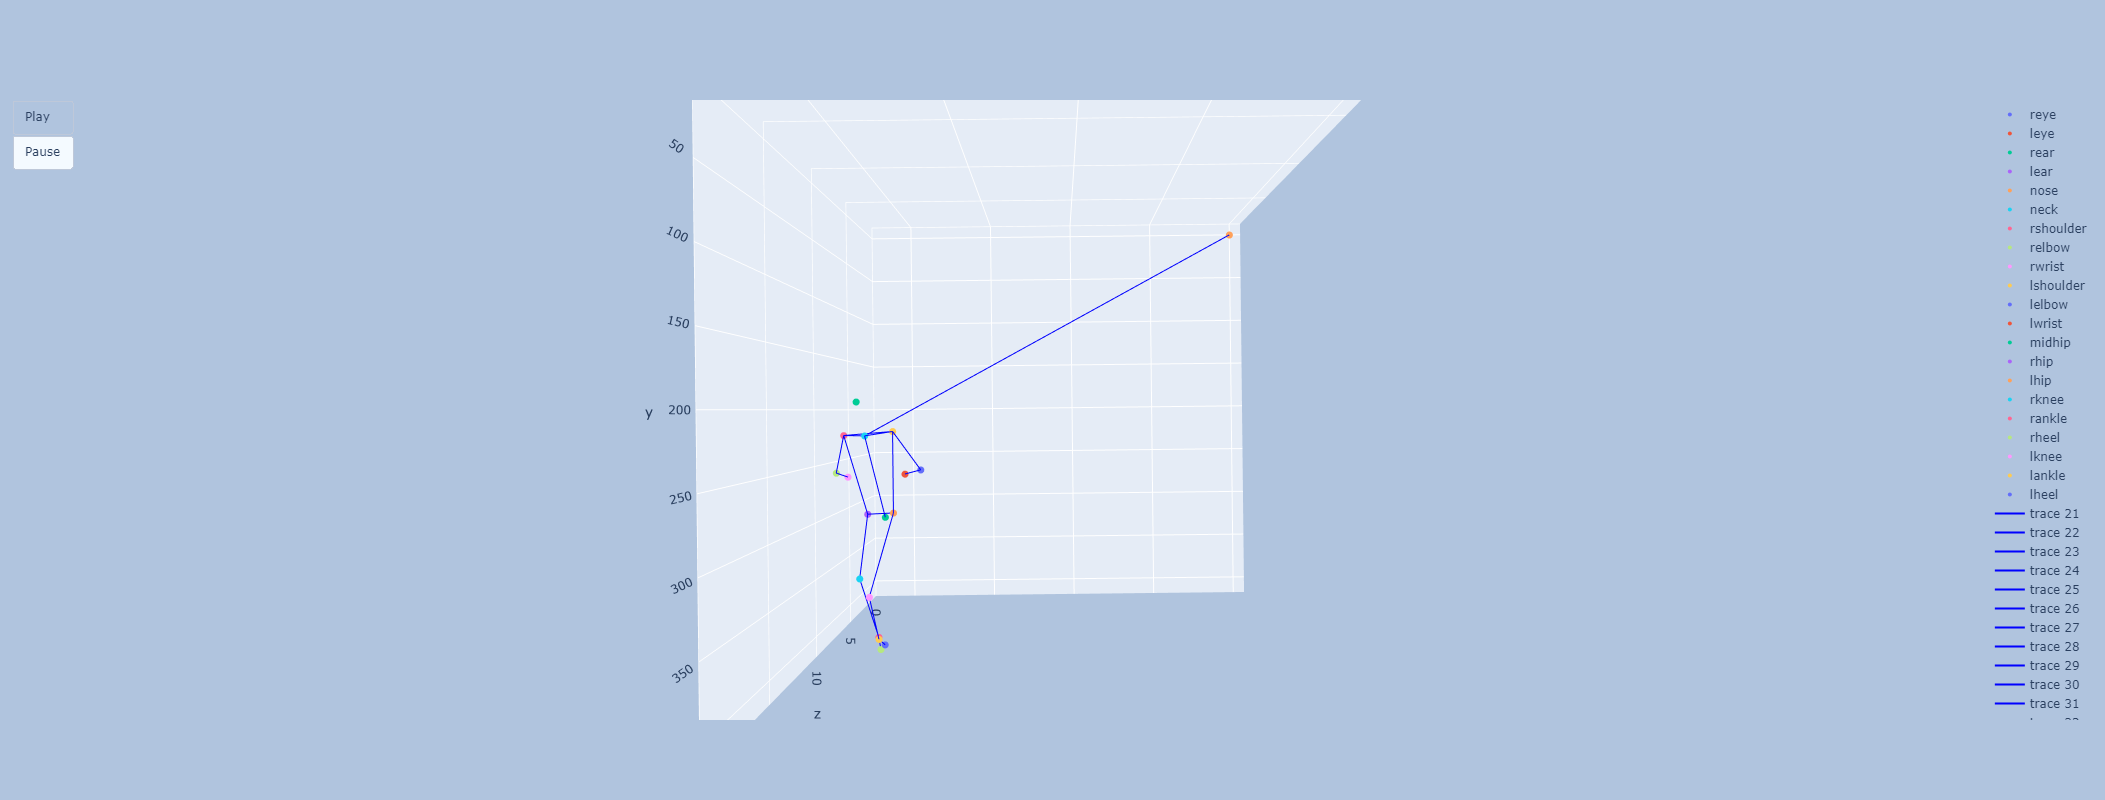

In [11]:
for df in df_Camera_list:
    print(df.shape)
    df['SessionTime'] = (df['timestamp'] - df['timestamp'].iloc[0])

    for part in body_parts: ## was body_parts
    # Splitting the string to separate x, y, z, confidence, and score
        df[[f'{part}_x', f'{part}_y', f'{part}_z', f'{part}_confidence']] = df[part].str.split(',', expand=True).iloc[:, :4].astype(float)
    #print(df.head())
    print("after ", df.shape)
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    print(df)
    #df = interpolate_df(df)
    print(df)
    plot_Camera_Data(df)
    break 